<a href="https://colab.research.google.com/github/Benjamin1118/DS-Unit-2-Kaggle-Challenge/blob/master/module_4_Benjamin_Bishop_assignment_kaggle_challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [22]:
import pandas as pd
import category_encoders as ce 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
  X = X.copy()
  #convert to datetime
  X['date_recorded']=pd.to_datetime(X['date_recorded'], infer_datetime_format= True)

  #extract components from date_recorded, then drop org col
  X['year_recorded']=X['date_recorded'].dt.year
  X['month_recored']= X['date_recorded'].dt.month
  X['day_recorded']= X['date_recorded'].dt.day 
  X=X.drop(columns = 'date_recorded')

  X['years']= X['year_recorded']- X['construction_year']

  #drop col rarely used
  unusable_variance = ['recorded_by', 'id']
  X=X.drop(columns = unusable_variance)

  #drop dup col
  duplicate_columns= ['quantity_group']
  X=X.drop(columns=duplicate_columns)

  #remove outliers in latitude
  X['latitude']= X['latitude'].replace(-2e-08, np.nan)

  #Replace zeros with nan values
  cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height','population']
  for col in cols_with_zeros:
    X[col]= X[col].replace(0,np.nan)

    return X



# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

#split train to train and val
target = 'status_group'
train, val = train_test_split(train, test_size = len(test),
                              stratify = train[target], random_state = 42)
#wrangle data
train= wrangle(train)
val = wrangle(val)
test = wrangle(test)
train.head()



,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,year_recorded,month_recored,day_recorded,years
45793,0.0,NaN,0,NaN,33.075583,-9.385449,Kwa Mwazembe,0,Lake Nyasa,Itaba,Mbeya,12,5,Ileje,Chitete,0,True,VWC,NaN,False,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional,2011,3,30,2011
26326,500.0,Dhv,285,DWE,36.228574,-8.207742,Kwamwampwaga,0,Rufiji,Igima,Morogoro,5,3,Kilombero,Mbingu,1000,True,NaN,NaN,True,1984.0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,soft,good,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,non functional,2011,2,28,27
53251,0.0,Finw,218,FinW,39.673635,-10.835281,Pachani,0,Ruvuma / Southern Coast,Mnyekehe,Mtwara,9,4,Tandahimba,Naputa,260,True,Water Board,Borehole,True,1982.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,2013,1,27,31
26791,500.0,Adb,1704,DWE,34.915589,-9.016965,Kwa Mwangayange Mfumbilwa,0,Rufiji,Ndanula,Iringa,11,4,Njombe,Igongolo,40,True,VWC,Ibiki gravity water scheme,False,2008.0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,2,27,3
2162,200.0,Dwe,1232,DWE,30.332034,-4.308921,Kwa Bungwa,0,Lake Tanganyika,Nyakerera,Kigoma,16,2,Kasulu,Kitagata,500,True,Water authority,Nyachenda,True,2003.0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2013,1,18,10


In [14]:
#arrange to X_features and y target
X_train = train.drop(columns = target)
y_train = train[target]
X_val= val.drop(columns= target)
y_val = val[target]
X_test = test


#make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs= -1)
)

#fit 
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_val)
print('Val acc', accuracy_score(y_val, y_pred))

Val acc 0.8106978687839532


In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[6990,  186,  622],
       [ 551,  328,  164],
       [1122,   73, 4322]])

In [17]:
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

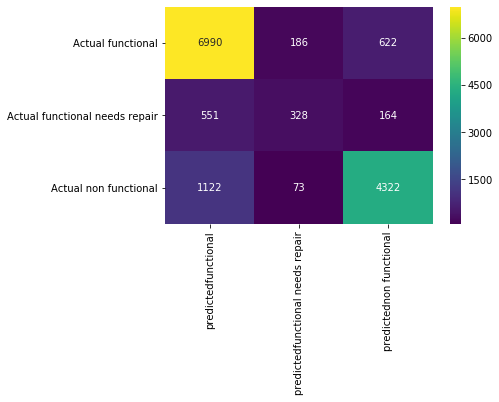

In [21]:
#make heat chart
def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'predicted{label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  table= pd.DataFrame(confusion_matrix(y_true, y_pred),
                      columns = columns, index = index)
  return sns.heatmap(table, annot= True, fmt = 'd', cmap= 'viridis')
plot_confusion_matrix(y_val, y_pred);